# Polyphase Filterbank for the Rollers algorithm

For a more efficient implementation of the Rollers pitch-shifting algorithm, a polyphase filter bank could be used.
The pitch shifting is done by frequency shifting of logarithmically spaced subbands.
By reducing the sample rate in these subbands, the performance of the algorithm could be improved.

I want to investigate, what the effects of the downsampling/upsampling in the subbands are and which synthesis filters are needed to synthesize the frequency-shifted subband signals to the pitch-shifted output signal.

First define a function to plot the magnitude spectrum of a signal and a filter bank class.

In [1]:
import numpy as np
from scipy import signal
import scipy.integrate as integrate
from scipy.io import wavfile
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 3]
from scipy.fft import rfft, fft, rfftfreq, fftfreq
import IPython.display as ipd

In [2]:
def plot_mag_spec(sig, fs, name="", negative=False, f_range=(20, 20000), db_range=(-40, 0), f_log=True):
    """
    Plot the magnitude spectrum of the signal 'sig'.
    sig:    signal to be analyzed
    fs:     sampling rate of sig
    name:   name of the plotted spectrum
    negative: show negative frequencies (default: False)
    f_range: define a frequency range for the spectrum (default: 20Hz to 20kHz)
    db_range: define a magnitude range in dB for the spectrum (default: 0dB to 100dB)
    f_log:  logarithmic or linear frequency axis? (default: True is logarithmic)
    """
    w = signal.hann(sig.size) # window
    if negative == False:
        # just positive frequencies
        freq = rfftfreq(sig.size, 1 / fs)
        spec = rfft(sig*w)
        mag = 20*np.log10(np.abs((1/sig.size)*spec))
        if f_log == True:
            plt.semilogx(freq, mag)
        else:
            plt.plot(freq, mag)
        plt.xlim(f_range)
    else:
        # positive and negative frequencies
        freq = fftfreq(sig.size, 1 / fs)
        mag = 20*np.log10(np.abs((1/sig.size)*fft(sig*w)))
        if f_log == True:
            freq = freq[1:] # omit 0Hz
            mag = mag[1:]
        plt.plot(freq, mag)
        plt.xlim((-f_range[1], f_range[1]))
        if f_log == True:
            plt.xscale('symlog')
    plt.ylim(db_range)
    plt.xlabel("f [Hz]")
    plt.ylabel("amplitude [dB]")
    plt.title(name)
    plt.show()

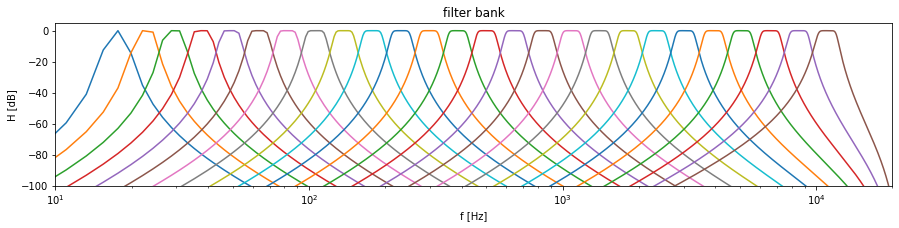

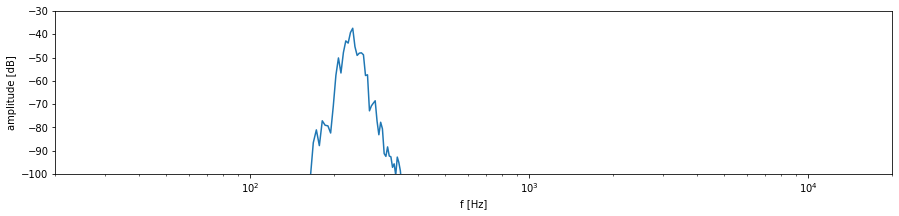

Bug: There are two filters less than specified


In [3]:
class Filterbank:
    """A  constant Q IIR butterworth filter bank for audio signal processing"""
    
    def __init__(self, n, order, fs, filt_type=""):
        self.n = n
        self.order = order
        self.fs = fs
        
        if filt_type == "third octave":
            # third-octave filter bank
            freq_offset = 2
            k = np.arange(n + 2) - n // 2 - freq_offset

            # center frequencies are defined relative to a bandpass with center frequency at 1kHz
            f_cs = np.power(2, k / 3) * 1000

            f_chs = [] # high cutoff frequencies
            f_cls = [] # low cutoff frequencies
            for k in range(1, f_cs.size-1):
                f_chs.append(np.sqrt(f_cs[k] * f_cs[k+1]))
                f_cls.append(np.sqrt(f_cs[k-1] * f_cs[k]))
        else:
            # log spaced filter bank
            # 2**4 = 16Hz
            # 14.3 = 20171Hz
            f = np.logspace(4, 14.3, n*3, base=2)

            # low cutoff frequencies
            f_cls = f[::3]

            # center frequencies
            f_cs = f[1::3]

            # high cutoff frequencies
            f_chs = f[2::3]

        filters = []
        for k in range(f_cs.size-2):
            sos = self.butter_bp(f_cls[k], f_chs[k])
            filters.append(sos)
        
        self.fcs = f_cs[1:-1]
        self.filters = filters
    
    def butter_bp(self, lowcut, highcut):
        """
        Design a butterworth bandpass filter and return the 'sos' filter.
        lowcut: low cutoff frequency
        highcut: high cutoff frequency
        """
        f_nyq = 0.5 * self.fs
        low = lowcut / f_nyq
        high = highcut / f_nyq
        return signal.butter(self.order, [low, high], btype='band', output='sos')
    
    def plot_filters(self):
        """Plot the magnitude spectrum of all filter of the filter bank."""
        for sos in self.filters:
            w, h = signal.sosfreqz(sos, worN=10000)
            plt.semilogx((self.fs * 0.5 / np.pi) * w[1:], 20*np.log10(np.abs(h[1:])))
            plt.ylim((-100, 5))
            plt.xlim((10, 20000))
            plt.ylabel('H [dB]')
            plt.xlabel('f [Hz]')
            plt.title('filter bank')
        plt.show()
    
    def filt(self, in_sig):
        """Filter the in_sig and return an array of the filtered signals."""
        filtered_signals = []
        for sos in self.filters:
            filtered_signals.append(signal.sosfilt(sos, in_sig))
        return filtered_signals

# test the Filterbank class
filtb = Filterbank(28, 4, 44100)
filtb.plot_filters()
noise = np.random.normal(0, 1, 10*1024)
filtered_noise = filtb.filt(noise)
plot_mag_spec(filtered_noise[10], 44100, db_range=[-100, -30])

print("Bug: There are two filters less than specified")

## Effects of down-/upsampling of subband signals

Let's start simple with a 2 channel filter bank and investiagte the effects of down-/upsampling on the spectrum of the subbands.

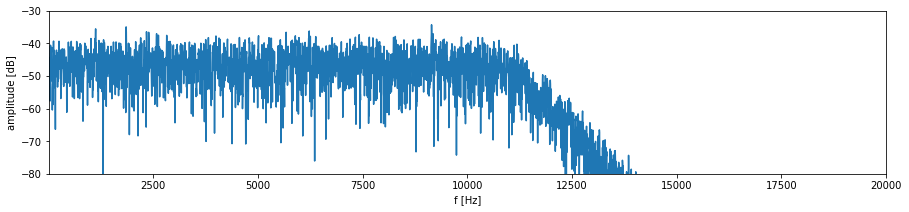

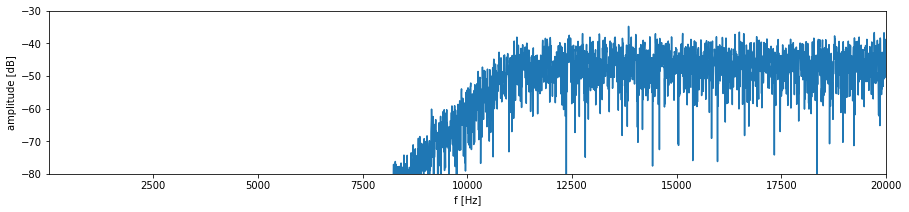

In [4]:
fs = 44100
fc = fs / 4
order = 11

# split the spectrum with a lowpass and a highpass at fc = f_nyq / 2
f_nyq = 0.5 * fs
f_norm = fc / f_nyq
lop = signal.butter(order, f_norm, btype='lowpass', output='sos')
hip = signal.butter(order, f_norm, btype='highpass', output='sos')

# filtering
noise = np.random.normal(0, 1, 10*1024)
low_band = signal.sosfilt(lop, noise)
high_band = signal.sosfilt(hip, noise)

# plot
plot_mag_spec(low_band, 44100, db_range=[-80, -30], f_log=False)
plot_mag_spec(high_band, 44100, db_range=[-80, -30], f_log=False)

We use a harmonic signal to track the effect on partials, since we usally get aliasing at downsampling signals.

In [5]:
def get_bl_saw(dur=10, freq=1000, n_partials=10, fs=44100):
    """bandlimited saw signal with quadratic decay of harmonics for good spectra"""
    t = np.linspace(0, dur, dur*fs)
    saw = np.zeros(t.size)
    for k in range(n_partials+1):
        k = k+1
        saw += (-1)**k * np.sin(2 * np.pi * k * freq * t) / (k**2)
    return -1.8 * saw / np.pi

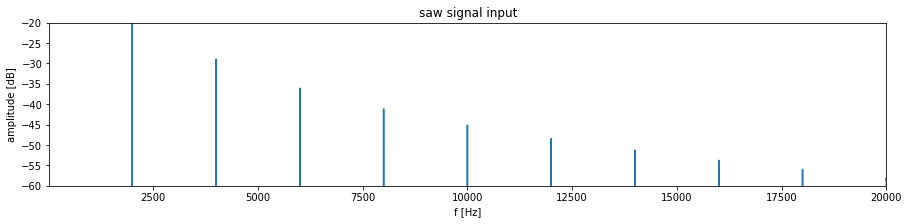

<ipython-input-2-7c2c2f4319ca>:17: RuntimeWarning: divide by zero encountered in log10
  mag = 20*np.log10(np.abs((1/sig.size)*spec))


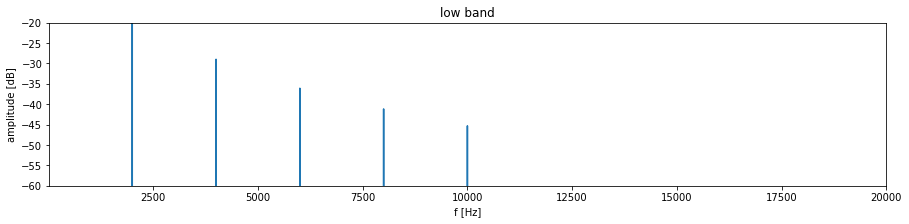

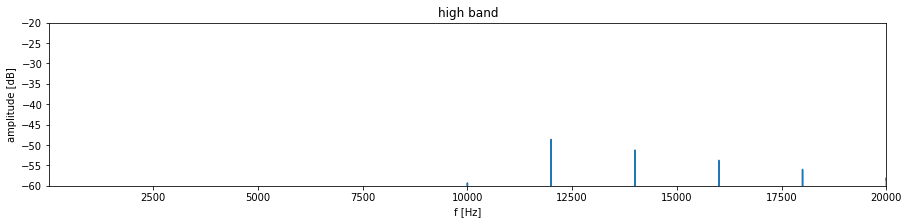

In [6]:
saw = get_bl_saw(freq=2000, fs=fs)

low_band = signal.sosfilt(lop, saw)
high_band = signal.sosfilt(hip, saw)

# plot
plot_mag_spec(saw, fs, db_range=[-60, -20], f_log=False, name="saw signal input")
plot_mag_spec(low_band, fs, db_range=[-60, -20], f_log=False, name="low band")
plot_mag_spec(high_band, fs, db_range=[-60, -20], f_log=False, name="high band")

In theory, we can do downsampling by the number of channels used.
If we half the sampling rate, Nyquist frequency gets halfed too, from 22050Hz to 11025Hz.

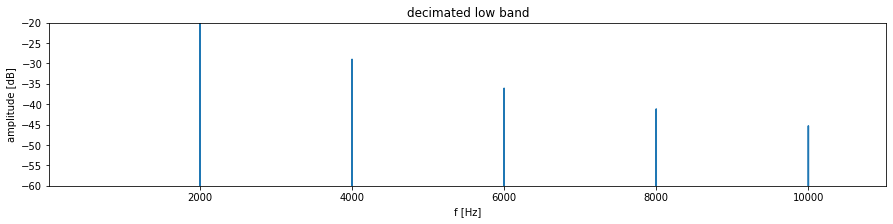

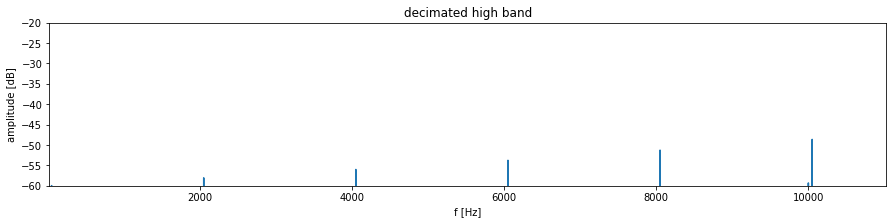

In [7]:
# decimate subband signals to half the sampling rate
N = 2
f_dec = fs / N
low_dec = low_band[::N]
high_dec = high_band[::N]

# plot
plot_mag_spec(low_dec, f_dec, db_range=[-60, -20], f_log=False, name="decimated low band", f_range=(20, 11025))
plot_mag_spec(high_dec, f_dec, db_range=[-60, -20], f_log=False, name="decimated high band", f_range=(20, 11025))

As we can see, the frequencies in the high band above 11025Hz get mirrored, which is aliasing.
The low frequency band gets spread out to the Nyquist frequency (equivalent to reducing the Nyquist frequency).
The high band gets flipped around the Nyquist frequency.
For ideal filters, there would be no aliasing.

To complete the filter bank, we do the synthesis part now.
The output signal is formed by upsampling, filtering and adding the subbands.

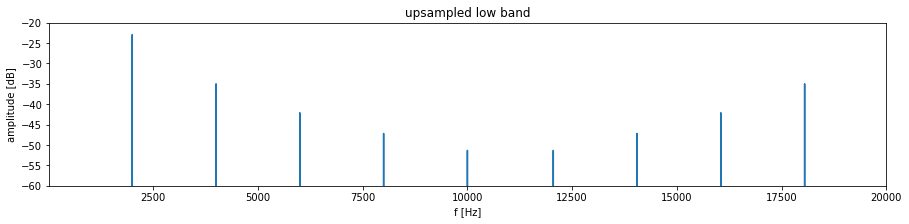

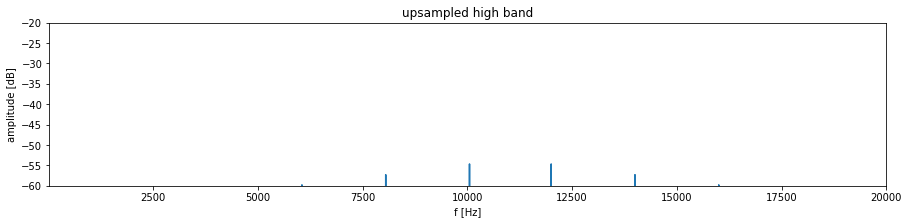

In [8]:
# upsampling
low_up = np.zeros(low_dec.size*N)
low_up[::2] = low_dec
high_up = np.zeros(high_dec.size*N)
high_up[::2] = high_dec


# plot
plot_mag_spec(low_up, fs, db_range=[-60, -20], f_log=False, name="upsampled low band")
plot_mag_spec(high_up, fs, db_range=[-60, -20], f_log=False, name="upsampled high band")

After upsampling, the upper part of the periodic spectrum of the signals appears in the spectrogram.
This is why synthesis filters are needed to reconstruct the original signal.

For synthesis filters, we choose the same filters as for the analysis.
Often the synthesis filters are derived for perfect or nearly perfect reconstruction of the input signal.
It is possible to achieve perfect reconstruction in magnitude and phase.

In this case we work with non ideal filters and do not care about phase, since the human ear is not sensitive to it.

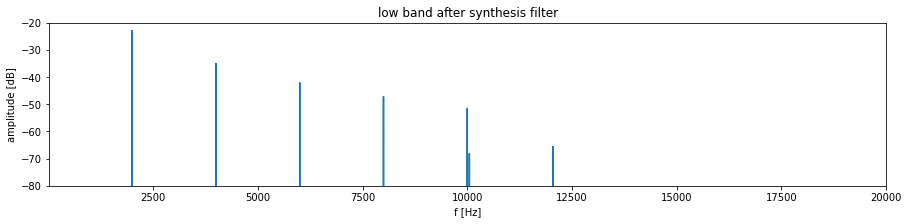

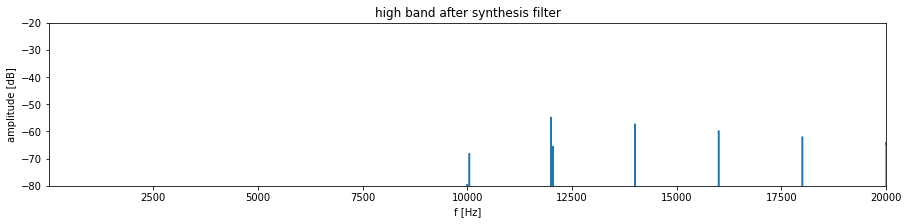

In [9]:
low_out = signal.sosfilt(lop, low_up)
high_out = signal.sosfilt(hip, high_up)

# plot
plot_mag_spec(low_out, fs, db_range=[-80, -20], f_log=False, name="low band after synthesis filter")
plot_mag_spec(high_out, fs, db_range=[-80, -20], f_log=False, name="high band after synthesis filter")

And reconstruct the signal by adding the filtered subbands.

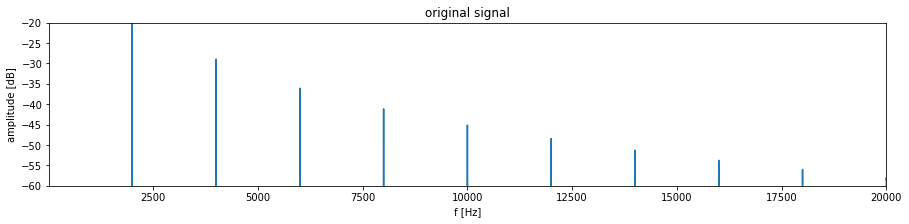

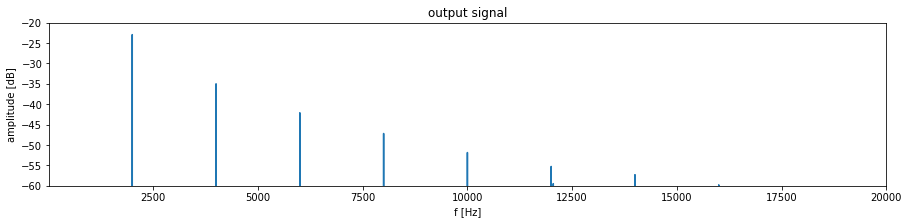

In [10]:
out = low_out + high_out

plot_mag_spec(saw, fs, db_range=[-60, -20], f_log=False, name="original signal")
plot_mag_spec(out, fs, db_range=[-60, -20], f_log=False, name="output signal")

This method works OK when using high order filters.
It would work even better, when there is some spacing between the filters.

Due to this results, for a filter bank with a lot of bands, there is a tradeoff between downsampling ratio, filter order and filter spacing.
This results in a tradeoff in computational complexity and aliasing (sound quality).


## Synthesis stage for Rollers

Another problem to be solved for the synthesis stage for the Rollers algorithm is, that we do frequency shifting in the subbands.
So we can not use the same synthesis filters as for the analysis.
__One solution is, to move the synthesis filters according to the frequency shift of the SSB in the subbands.__

In [11]:
def ssb(sig, f_shift, fs):
    """
    frequency shifting with single sideband modulation
    sig: signal to be frequency shifted
    f_shift: frequency amount of shifting
    fs: sampling frequency of sig
    """
    t = np.linspace(0, sig.size/fs, sig.size)
    x = np.exp(1j*2*np.pi*f_shift*t)
    return (signal.hilbert(sig) * x).real

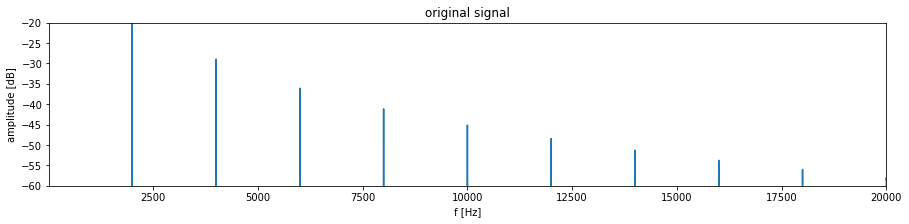

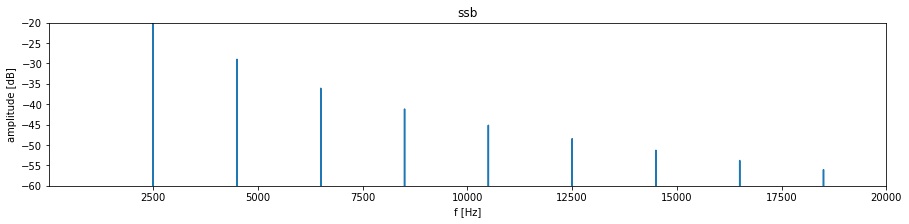

In [12]:
y = ssb(saw, 500, fs)

plot_mag_spec(saw, fs, db_range=[-60, -20], f_log=False, name="original signal")
plot_mag_spec(y, fs, db_range=[-60, -20], f_log=False, name="ssb")

## 3 band SSB with synthesis according to frequency shift

Let's make

* three subbands by the analysis stage

* do frequency shifting per subband like Rollers and

* do the analysis stage with the according filters.

In [13]:
saw = get_bl_saw(freq=2000, n_partials=10)

# analysis
fs = 44100
f_nyq = 0.5 * fs
N = 3
fc1 = f_nyq / N
fc2 = 2 * f_nyq / N
order = 11

# split the spectrum with a lowpass, a bandpass and a highpass
f_norm1 = fc1 / f_nyq
f_norm2 = fc2 / f_nyq
a_lop = signal.butter(order, f_norm1, btype='lowpass', output='sos')
a_bp = signal.butter(order, [f_norm1, f_norm2], btype='band', output='sos')
a_hip = signal.butter(order, f_norm2, btype='highpass', output='sos')

# filtering
low_band = signal.sosfilt(a_lop, saw)
mid_band = signal.sosfilt(a_bp, saw)
high_band = signal.sosfilt(a_hip, saw)

In [14]:
# decimation
low_dec = low_band[::N]
mid_dec = mid_band[::N]
high_dec = high_band[::N]

In [15]:
# shift via subband mid frequencies
#TODO: Das muss jetzt wahrscheinlich umgerechnet werden und die subbänder sind ja sogar verkehrt...
# Vielleicht muss man bei geraden subbändern in die andere richtung shiften, aber dann hat man keinen Platz...
psr = 1.1 # pitch shifting ratio

fmid = fc1 / 2
f_shift1 = fmid * psr - fmid
f_shift2 = (fc1 + fmid) * psr - (fc1 + fmid)
f_shift3 = (fc2 + fmid) * psr - (fc2 + fmid)

print(f_shift1, f_shift2, f_shift3)

367.50000000000045 1102.5000000000018 1837.5


In [16]:
low_shift = ssb(low_dec, f_shift1, fs/N)
mid_shift = ssb(mid_dec, f_shift2, fs/N)
high_shift = ssb(high_dec, f_shift3, fs/N)

In [17]:
# upsampling
low_up = np.zeros(low_shift.size*N)
low_up[::N] = low_shift
mid_up = np.zeros(mid_shift.size*N)
mid_up[::N] = mid_shift
high_up = np.zeros(high_shift.size*N)
high_up[::N] = high_shift

Now that we have shifted the spectra by $f_{shift, i}$, we design the synthesis filters accordingly to the frequency shift.

In [18]:
# synthesis filters according to frequency shift
f_norm1 = (fc1 + f_shift1) / f_nyq
f_norm2 = (fc2 + f_shift2) / f_nyq
s_lop = signal.butter(order, f_norm1, btype='lowpass', output='sos')
s_bp = signal.butter(order, [f_norm1, f_norm2], btype='band', output='sos')
# make a bandpass instead of a highpass for anti aliasing
s_hip_bp = signal.butter(order, [f_norm2, 0.99], btype='band', output='sos')

# filtering
low_out = signal.sosfilt(s_lop, low_up)
mid_out = signal.sosfilt(s_bp, mid_up)
high_out = signal.sosfilt(s_hip_bp, high_up)

In [19]:
# reconstruction
out = low_out + mid_out + high_out

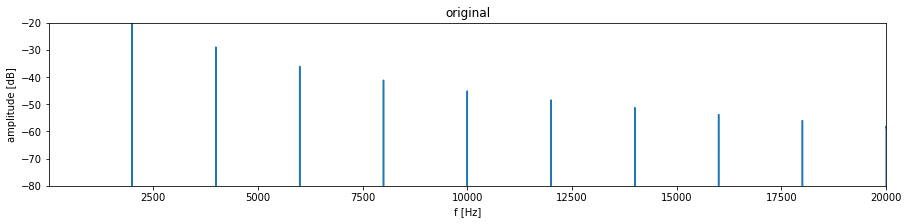

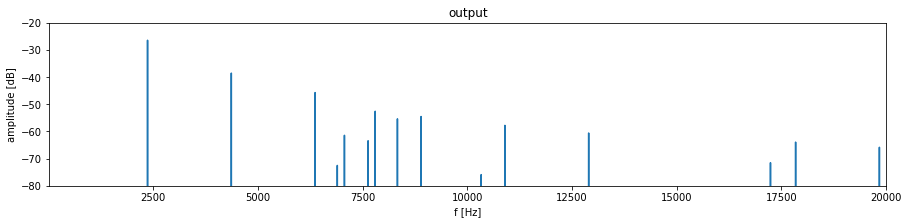

In [20]:
plot_mag_spec(saw, fs, db_range=[-80, -20], f_log=False, name="original")
plot_mag_spec(out, fs, db_range=[-80, -20], f_log=False, name="output")

This is clearly wrong.
To learn something from it make a subplot with all three signals for all stages.

plot:

* original signal

* analysis filtering into 3 subbands

* decimation of subbands

* frequency shifting in subbands

* upsampling of subbands

* synthesis filtering

* reconstruction



In [21]:
def m_spec(sig, fs):
    w = signal.hann(sig.size) # window
    # just positive frequencies
    freq = rfftfreq(sig.size, 1 / fs)
    spec = rfft(sig*w)
    mag = 20*np.log10(np.abs((1/sig.size)*spec))
    return freq, mag

In [22]:
def m_filt_spec(sos, fs):
    w, h = signal.sosfreqz(sos, worN=10000)
    freq = (fs * 0.5 / np.pi) * w[1:]
    mag = 20*np.log10(np.abs(h[1:]))
    return freq, mag

<ipython-input-21-2bb7f7587ed1>:6: RuntimeWarning: divide by zero encountered in log10
  mag = 20*np.log10(np.abs((1/sig.size)*spec))


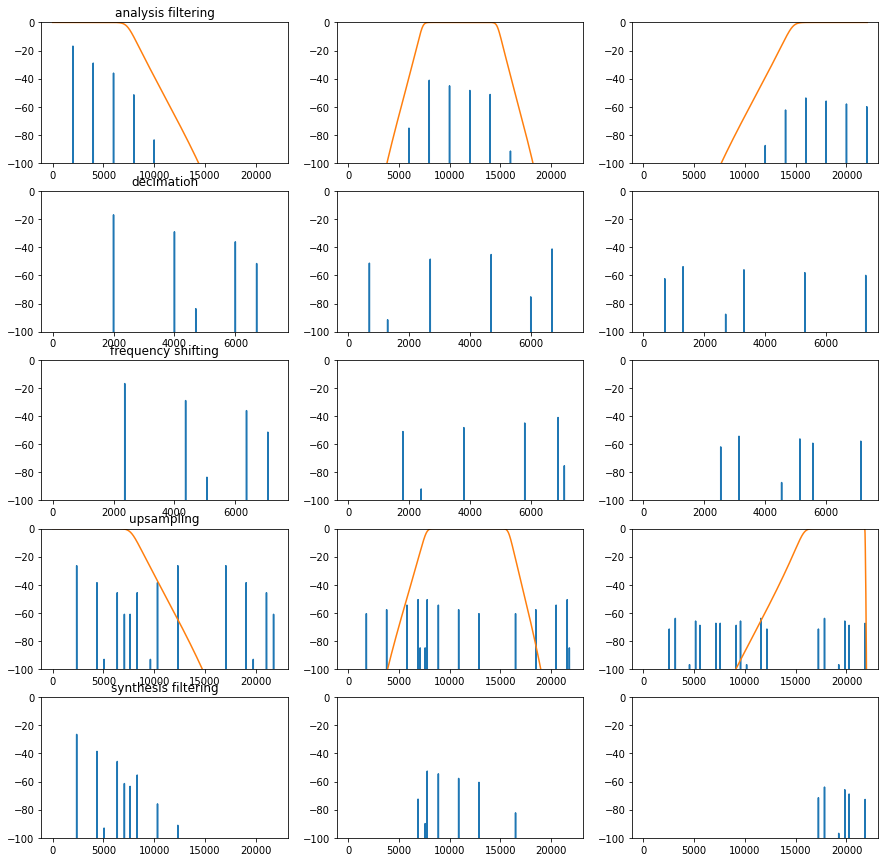

In [24]:
# plot
fig, axs = plt.subplots(5, 3)
plt.rcParams['figure.figsize'] = [15, 15]

# analysis filtering
axs[0,0].set_title("analysis filtering")
f, m = m_spec(low_band, fs)
axs[0,0].plot(f, m)
f, m = m_spec(mid_band, fs)
axs[0,1].plot(f, m)
f, m = m_spec(high_band, fs)
axs[0,2].plot(f, m)
# filters
f, m = m_filt_spec(a_lop, fs)
axs[0,0].plot(f, m)
f, m = m_filt_spec(a_bp, fs)
axs[0,1].plot(f, m)
f, m = m_filt_spec(a_hip, fs)
axs[0,2].plot(f, m)


# decimation
f, m = m_spec(low_dec, fs/N)
axs[1,0].plot(f, m)
axs[1,0].set_title("decimation")
f, m = m_spec(mid_dec, fs/N)
axs[1,1].plot(f, m)
f, m = m_spec(high_dec, fs/N)
axs[1,2].plot(f, m)


# frequency shifting
f, m = m_spec(low_shift, fs/N)
axs[2,0].plot(f, m)
axs[2,0].set_title("frequency shifting")
f, m = m_spec(mid_shift, fs/N)
axs[2,1].plot(f, m)
f, m = m_spec(high_shift, fs/N)
axs[2,2].plot(f, m)


# upsampling
axs[3,0].set_title("upsampling")
f, m = m_spec(low_up, fs)
axs[3,0].plot(f, m)
f, m = m_spec(mid_up, fs)
axs[3,1].plot(f, m)
f, m = m_spec(high_up, fs)
axs[3,2].plot(f, m)

# filters
f, m = m_filt_spec(s_lop, fs)
axs[3,0].plot(f, m)
f, m = m_filt_spec(s_bp, fs)
axs[3,1].plot(f, m)
f, m = m_filt_spec(s_hip_bp, fs)
axs[3,2].plot(f, m)


# synthesis filtering
axs[4,0].set_title("synthesis filtering")
f, m = m_spec(low_out, fs)
axs[4,0].plot(f, m)
f, m = m_spec(mid_out, fs)
axs[4,1].plot(f, m)
f, m = m_spec(high_out, fs)
axs[4,2].plot(f, m)

for axis_list in axs:
    for axis in axis_list:
        axis.set_ylim((-100, 0))
    

plt.show()

### Was passiert hier?

In der ersten Zeile werden die Subbänder aus dem Eingangssignal gefiltert.

In der zweiten Zeile wird auf ein drittel der originalen sampling Frequenz dezimiert (fnyq_new=7350).
Teiltöne außerhalb des erlaubten Bands verursachen Aliasing und das mittlere Band ist gespiegelt.

Das frequency shifting verursacht weiteres Aliasing, weil die Teiltöne an der Nyquist Frequenz gespiegelt werden.

Beim Upsampling wird unser "Spektrum-Fenster" auf 3 abwechselnd gespiegelte Spektrum-Perioden gesetzt.

Die Synthese Filter filtern das vermeintlich richtig verschobene Spektrum und erzeugen die Synthese Signale, die addiert das Ausgangssignal ergeben.


### Was ist schief gelaufen?

1. Nach der Dezimierung gibt es Aliasing durch das nicht ideale filtern und durch die kritische neue Samplerate (critically sampled filter bank).

2. Das mittlere Band is verkehrt herum und wird vom frequency shifter in die falsche Richtung geschoben.


## Conclusio:

Eine Filterbank mit frequency shifter in den Subbändern funktioniert nur nahe der originaen Sample rate.
Genau durch die Frequenzverschiebung wird Aliasing verursacht.
Zusätzlich müssten Zeitvariante Filter als Synthese-Filter verwendet werden.